In [1]:
import pandas as pd

In [2]:
import tensorflow as tf
train_data = pd.read_csv('./sign_mnist_train/sign_mnist_train.csv')
test_data = pd.read_csv('./sign_mnist_test/sign_mnist_test.csv')

x_train = train_data.iloc[:, 1:].values
x_test = test_data.iloc[:, 1:].values

y_train = train_data.iloc[:, 0].values #Integer labels from 0 - 25
y_test = test_data.iloc[:, 0].values

x_train = x_train / 255.0 #Normalizing the dataset
x_test = x_test / 255.0

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

#resizing images to work 
x_train = tf.image.resize(x_train, [32, 32])
x_test = tf.image.resize(x_test, [32, 32])

x_train = tf.repeat(x_train, 3, axis=-1)
x_test = tf.repeat(x_test, 3, axis=-1)



In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the ResNet50 model without the top classification layer, specifying the input shape
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


# Create a new model on top of ResNet50
model = Sequential([
    base_model,                     # Add the base ResNet50 model
    GlobalAveragePooling2D(),        # Use global average pooling to reduce dimensions
    Dense(256, activation='relu'),   # Add a dense layer for more learning capacity
    Dropout(0.5),                    # Dropout for regularization
    Dense(25, activation='softmax')  # Final output layer with 25 classes (change as needed)
])

# Compile the model with an optimizer and loss function suitable for classification
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 25)                6425      
                                                                 
Total params: 24118681 (92.01 MB)
Trainable params: 24065561 (91.80 MB)
Non-trainable params: 53120 (207.50 KB)
________

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [5]:

# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=5, validation_data=(x_test, y_test))

Epoch 1/5


858/858 [==============================] - 720s 815ms/step - loss: 1.7359 - accuracy: 0.5188 - val_loss: 3.0531 - val_accuracy: 0.2388
Epoch 2/5
858/858 [==============================] - 699s 815ms/step - loss: 0.3979 - accuracy: 0.8754 - val_loss: 0.1460 - val_accuracy: 0.9598
Epoch 3/5
858/858 [==============================] - 758s 884ms/step - loss: 0.1999 - accuracy: 0.9414 - val_loss: 0.0720 - val_accuracy: 0.9806
Epoch 4/5
858/858 [==============================] - 896s 1s/step - loss: 0.1325 - accuracy: 0.9616 - val_loss: 0.0485 - val_accuracy: 0.9841
Epoch 5/5
858/858 [==============================] - 1029s 1s/step - loss: 0.1088 - accuracy: 0.9691 - val_loss: 0.0308 - val_accuracy: 0.9922


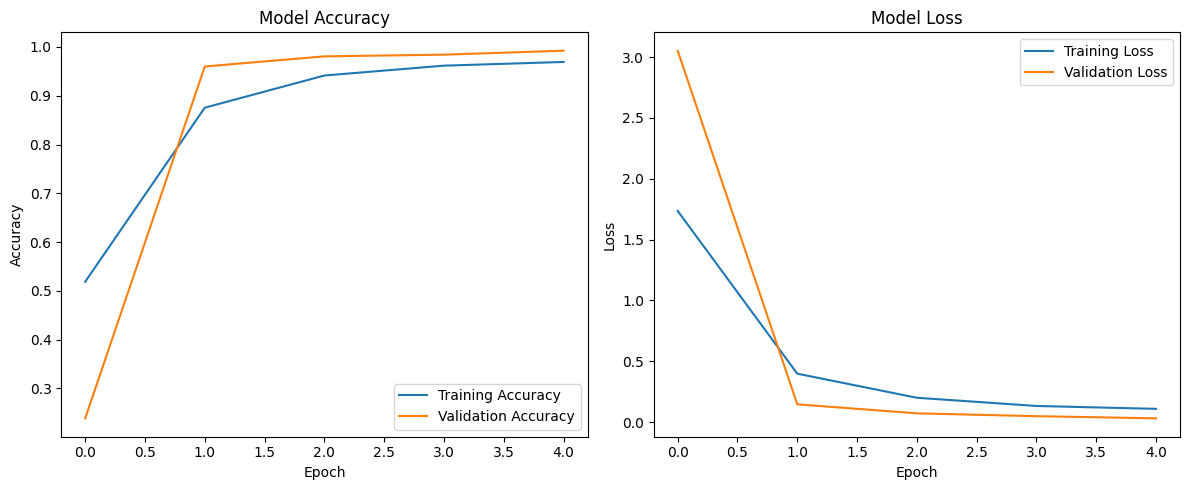

In [6]:
import matplotlib.pyplot as plt

# Assuming you have stored the history from model training
# Example: history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Show plots
plt.tight_layout()
plt.show()


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Evaluate the model on the test set to get loss and accuracy
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_acc}')

# Generate predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# If y_test is already in label format, no need for np.argmax
y_true = y_test  # Use y_test directly if it's not one-hot encoded

# Calculate additional metrics
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


225/225 [==============================] - 32s 142ms/step - loss: 0.0308 - accuracy: 0.9922
Test loss: 0.030758727341890335
Test accuracy: 0.9921918511390686
225/225 [==============================] - 36s 154ms/step
Precision: 0.9926638566891679
Recall: 0.9921918572225321
F1 Score: 0.992213043439157


In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')


225/225 [==============================] - 20s 89ms/step - loss: 0.0327 - accuracy: 0.9908
Test accuracy: 0.9907975196838379


In [ ]:
#Run this to save the model
model.save('hand_sign_mnist_model_resNet.h5')


c:\Users\karte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('hand_sign_mnist_model_resNet.h5')


In [ ]:
import cv2
import mediapipe as mp
import numpy as np

# Initialize MediaPipe hand detector
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=2)
mp_draw = mp.solutions.drawing_utils

# Start webcam feed
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert the image to RGB as Mediapipe uses RGB images
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Detect hands in the frame
    results = hands.process(rgb_frame)
    
    # Draw landmarks and connections if hands are detected
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:

            # Get image dimensions
            h, w, c = frame.shape

            # Get coordinates of hand landmarks
            landmark_points = []
            for lm in hand_landmarks.landmark:
                cx, cy = int(lm.x * w), int(lm.y * h)
                landmark_points.append((cx, cy))

            # Calculate the bounding box around the hand
            x_min = min([point[0] for point in landmark_points])
            x_max = max([point[0] for point in landmark_points])
            y_min = min([point[1] for point in landmark_points])
            y_max = max([point[1] for point in landmark_points])

            # Add some padding to the bounding box
            padding = 20
            x_min = max(0, x_min - padding)
            x_max = min(w, x_max + padding)
            y_min = max(0, y_min - padding)
            y_max = min(h, y_max + padding)

            # Calculate the width and height of the bounding box
            box_width = x_max - x_min
            box_height = y_max - y_min

            # Find the larger of the width or height to make the bounding box a square
            box_size = max(box_width, box_height)

            # Adjust the x and y coordinates to make the bounding box square
            x_center = (x_min + x_max) // 2
            y_center = (y_min + y_max) // 2

            x_min = max(0, x_center - box_size // 2)
            x_max = min(w, x_center + box_size // 2)
            y_min = max(0, y_center - box_size // 2)
            y_max = min(h, y_center + box_size // 2)

            # Extract the region of interest (hand) as a square
            hand_roi = frame[y_min:y_max, x_min:x_max]

            # Resize the ROI to 96x96 to match MobileNet input size
            hand_roi_resized = cv2.resize(hand_roi, (96, 96))
            
            # Ensure the ROI has 3 channels (RGB) for MobileNet input
            if hand_roi_resized.shape[-1] == 1:  # If it's grayscale
                hand_roi_rgb = cv2.cvtColor(hand_roi_resized, cv2.COLOR_GRAY2RGB)
            else:
                hand_roi_rgb = hand_roi_resized  # Use the resized ROI directly if already RGB

            # Normalize the image and expand dimensions for model input
            hand_cnn_input = hand_roi_rgb / 255.0
            hand_cnn_input = np.expand_dims(hand_cnn_input, axis=0)

            # Predict the class
            predictions = model.predict(hand_cnn_input)
            predicted_class = np.argmax(predictions, axis=1)[0]

            # Display the predicted class on the frame
            cv2.putText(frame, chr(predicted_class + 65), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 
                        1, (0, 255, 0), 2, cv2.LINE_AA)

            # Draw the bounding box around the hand
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        
    # Display the result
    cv2.imshow("Hand Detection", frame)
    
    # Break loop on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


c:\Users\karte\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 [==============================] - 0s 33ms/step
